# Generative Adverserial Networks in PyTorch

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



C:\Users\Chandan\anaconda3\envs\dl\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1) # Ranges the pixel values from 0 to 1

Label: 5


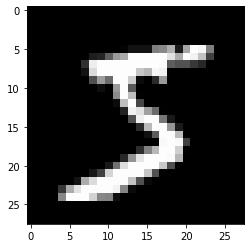

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 8, 2, 7, 9, 8, 8, 4, 8, 5, 4, 1, 2, 3, 2, 0, 2, 1, 2, 7, 0, 0, 7, 6,
        7, 5, 8, 8, 2, 4, 6, 2, 2, 9, 4, 1, 9, 2, 0, 2, 6, 3, 7, 7, 9, 6, 4, 1,
        4, 7, 0, 8, 9, 7, 3, 6, 0, 4, 2, 5, 5, 2, 3, 5, 7, 4, 5, 2, 1, 3, 8, 7,
        6, 4, 7, 3, 6, 2, 2, 4, 3, 2, 9, 1, 8, 0, 3, 3, 7, 6, 9, 6, 0, 7, 2, 8,
        6, 3, 1, 3])


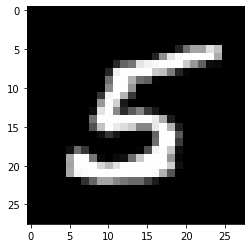

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

# Discriminator Network

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()) # Sigmoid gives a value from 0 to 1 which represents the probability of the generated image being general.

In [11]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator Network

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size)) # Creates a batch of 2 latent vectors
gen_imgs = denorm(y.reshape((-1, 28,28)).detach()) # detach hides various computations and gradients associated with the model.

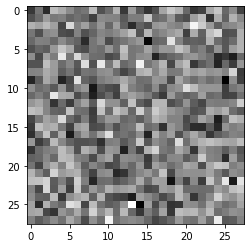

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

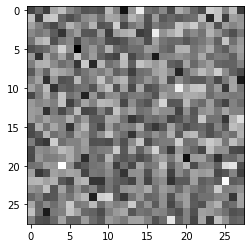

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.

Let's move the generator to the chosen device.

In [17]:
G.to(device);

# Discriminator Training

In [18]:
criterion = nn.BCELoss() # Loss function
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

# Generator Training

In [20]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Training the Model

In [21]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

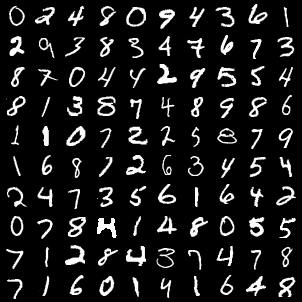

In [22]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


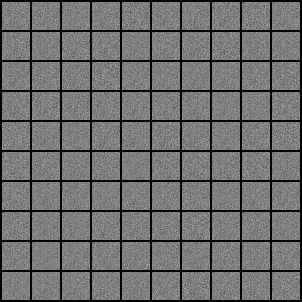

In [23]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


In [24]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0344, g_loss: 4.2026, D(x): 1.00, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1693, g_loss: 5.2586, D(x): 0.96, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.0371, g_loss: 4.8954, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1534, g_loss: 3.9912, D(x): 0.94, D(G(z)): 0.07
Epoch [1/300], Step [400/600], d_loss: 0.0583, g_loss: 4.6625, D(x): 0.97, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.6571, g_loss: 3.3099, D(x): 0.89, D(G(z)): 0.32
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3727, g_loss: 4.0885, D(x): 0.91, D(G(z)): 0.18
Epoch [2/300], Step [400/600], d_loss: 0.1678, g_loss: 3.6954, D(x): 0.93, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.4511, g_loss: 2.5061, D(x): 0.83, D(G(z)): 0.14
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5526, g_loss: 2.8006, D(x): 0.94, D(G(z)): 0.33
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.6060, g_loss: 3.1596, D(x): 0.82, D(G(z)): 0.16
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.4600, g_loss: 2.9002, D(x): 0.88, D(G(z)): 0.14
Epoch [28/300], Step [400/600], d_loss: 0.3850, g_loss: 4.0255, D(x): 0.87, D(G(z)): 0.08
Epoch [28/300], Step [600/600], d_loss: 0.4344, g_loss: 3.5639, D(x): 0.94, D(G(z)): 0.23
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4079, g_loss: 3.1186, D(x): 0.93, D(G(z)): 0.20
Epoch [29/300], Step [400/600], d_loss: 0.5325, g_loss: 3.6022, D(x): 0.85, D(G(z)): 0.13
Epoch [29/300], Step [600/600], d_loss: 0.3120, g_loss: 3.7194, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.5023, g_loss: 3.9620, D(x): 0.91, D(G(z)): 0.21
Epoch [30/300], Step [400/600], d_loss: 0.4967, g_loss: 2.3553, D(x): 0.89, D(G(z)): 0.22
Epoch [30/300], Step [600/600], d_loss: 0.4694, g_loss: 4.0868, D(x): 0.85, D(G(z)): 0.11
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.7605, g_loss: 2.2038, D(x): 0.78, D(G(z)): 0.24
Epoch [55/300], Step [600/600], d_loss: 0.6426, g_loss: 1.9146, D(x): 0.79, D(G(z)): 0.20
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5455, g_loss: 2.0648, D(x): 0.87, D(G(z)): 0.20
Epoch [56/300], Step [400/600], d_loss: 0.6601, g_loss: 2.0512, D(x): 0.85, D(G(z)): 0.26
Epoch [56/300], Step [600/600], d_loss: 0.6575, g_loss: 2.1609, D(x): 0.77, D(G(z)): 0.20
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.7570, g_loss: 2.1637, D(x): 0.83, D(G(z)): 0.29
Epoch [57/300], Step [400/600], d_loss: 0.5829, g_loss: 2.0375, D(x): 0.86, D(G(z)): 0.22
Epoch [57/300], Step [600/600], d_loss: 0.6473, g_loss: 3.4734, D(x): 0.78, D(G(z)): 0.20
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.5726, g_loss: 2.9132, D(x): 0.85, D(G(z)): 0.25
Epoch [58/300], Step [400/600], d_loss: 0.7299, g_loss: 2.8123, D(x): 0.84, D(G(z)): 0.30
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.9473, g_loss: 1.9525, D(x): 0.83, D(G(z)): 0.39
Epoch [83/300], Step [400/600], d_loss: 0.7771, g_loss: 2.3921, D(x): 0.85, D(G(z)): 0.35
Epoch [83/300], Step [600/600], d_loss: 0.8955, g_loss: 2.0778, D(x): 0.79, D(G(z)): 0.34
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 1.1484, g_loss: 2.5408, D(x): 0.55, D(G(z)): 0.17
Epoch [84/300], Step [400/600], d_loss: 0.6734, g_loss: 1.5471, D(x): 0.78, D(G(z)): 0.24
Epoch [84/300], Step [600/600], d_loss: 0.5326, g_loss: 2.2954, D(x): 0.76, D(G(z)): 0.14
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7237, g_loss: 2.1785, D(x): 0.75, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.8923, g_loss: 1.5991, D(x): 0.77, D(G(z)): 0.32
Epoch [85/300], Step [600/600], d_loss: 0.8081, g_loss: 1.8011, D(x): 0.77, D(G(z)): 0.30
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.7538, g_loss: 2.7605, D(x): 0.71, D(G(z)): 0.15
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 1.0395, g_loss: 1.4058, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9123, g_loss: 1.7903, D(x): 0.68, D(G(z)): 0.27
Epoch [111/300], Step [400/600], d_loss: 1.0747, g_loss: 1.5839, D(x): 0.67, D(G(z)): 0.31
Epoch [111/300], Step [600/600], d_loss: 0.8803, g_loss: 1.7488, D(x): 0.69, D(G(z)): 0.25
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.7290, g_loss: 1.8254, D(x): 0.75, D(G(z)): 0.28
Epoch [112/300], Step [400/600], d_loss: 0.7977, g_loss: 1.9300, D(x): 0.77, D(G(z)): 0.30
Epoch [112/300], Step [600/600], d_loss: 0.8640, g_loss: 1.9179, D(x): 0.68, D(G(z)): 0.25
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7635, g_loss: 1.8887, D(x): 0.75, D(G(z)): 0.25
Epoch [113/300], Step [400/600], d_loss: 0.9661, g_loss: 1.2591, D(x): 0.72, D(G(z)): 0.33
Epoch [113/300], Step [600/600], d_loss: 0.8281, g_loss: 1.8021, D(x): 0.68, D(G(z)): 0.21
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9944, g_loss: 1.8398, D(x): 0.60, D(G(z)): 0.19
Epoch [138/300], Step [400/600], d_loss: 1.0333, g_loss: 1.3518, D(x): 0.71, D(G(z)): 0.36
Epoch [138/300], Step [600/600], d_loss: 0.8920, g_loss: 1.9169, D(x): 0.63, D(G(z)): 0.22
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0789, g_loss: 1.1248, D(x): 0.69, D(G(z)): 0.39
Epoch [139/300], Step [400/600], d_loss: 0.9477, g_loss: 1.5222, D(x): 0.66, D(G(z)): 0.27
Epoch [139/300], Step [600/600], d_loss: 1.0174, g_loss: 1.4530, D(x): 0.71, D(G(z)): 0.34
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.9078, g_loss: 1.7449, D(x): 0.65, D(G(z)): 0.23
Epoch [140/300], Step [400/600], d_loss: 0.9524, g_loss: 1.4749, D(x): 0.67, D(G(z)): 0.27
Epoch [140/300], Step [600/600], d_loss: 1.0744, g_loss: 1.6609, D(x): 0.61, D(G(z)): 0.27
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8924, g_loss: 1.9513, D(x): 0.69, D(G(z)): 0.29
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.8214, g_loss: 1.4092, D(x): 0.72, D(G(z)): 0.28
Epoch [165/300], Step [600/600], d_loss: 1.0019, g_loss: 1.5451, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0199, g_loss: 1.4073, D(x): 0.62, D(G(z)): 0.27
Epoch [166/300], Step [400/600], d_loss: 0.9052, g_loss: 1.2976, D(x): 0.73, D(G(z)): 0.33
Epoch [166/300], Step [600/600], d_loss: 0.8714, g_loss: 1.5620, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9149, g_loss: 1.5519, D(x): 0.78, D(G(z)): 0.38
Epoch [167/300], Step [400/600], d_loss: 0.8602, g_loss: 1.2622, D(x): 0.79, D(G(z)): 0.37
Epoch [167/300], Step [600/600], d_loss: 1.0773, g_loss: 1.4100, D(x): 0.58, D(G(z)): 0.26
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.8098, g_loss: 1.7611, D(x): 0.78, D(G(z)): 0.33
Epoch [168/300], Step [400/600], d_loss: 1.0528, g_loss: 1.8863, D(x): 0.67, D(G(z)): 0.33
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.0843, g_loss: 1.7233, D(x): 0.68, D(G(z)): 0.36
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9370, g_loss: 1.6137, D(x): 0.72, D(G(z)): 0.34
Epoch [193/300], Step [400/600], d_loss: 0.9785, g_loss: 1.6135, D(x): 0.58, D(G(z)): 0.21
Epoch [193/300], Step [600/600], d_loss: 1.0027, g_loss: 1.2950, D(x): 0.73, D(G(z)): 0.38
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9173, g_loss: 1.4832, D(x): 0.71, D(G(z)): 0.32
Epoch [194/300], Step [400/600], d_loss: 0.8721, g_loss: 1.4020, D(x): 0.75, D(G(z)): 0.34
Epoch [194/300], Step [600/600], d_loss: 0.8824, g_loss: 1.6037, D(x): 0.75, D(G(z)): 0.36
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9409, g_loss: 1.7683, D(x): 0.67, D(G(z)): 0.27
Epoch [195/300], Step [400/600], d_loss: 1.0043, g_loss: 1.8503, D(x): 0.65, D(G(z)): 0.30
Epoch [195/300], Step [600/600], d_loss: 0.8043, g_loss: 1.7216, D(x): 0.75, D(G(z)): 0.31
Saving

Epoch [220/300], Step [200/600], d_loss: 1.0209, g_loss: 1.3125, D(x): 0.71, D(G(z)): 0.38
Epoch [220/300], Step [400/600], d_loss: 1.0376, g_loss: 1.7667, D(x): 0.68, D(G(z)): 0.33
Epoch [220/300], Step [600/600], d_loss: 1.1529, g_loss: 1.6046, D(x): 0.55, D(G(z)): 0.25
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9366, g_loss: 1.2440, D(x): 0.76, D(G(z)): 0.40
Epoch [221/300], Step [400/600], d_loss: 0.9230, g_loss: 1.5344, D(x): 0.67, D(G(z)): 0.31
Epoch [221/300], Step [600/600], d_loss: 1.0146, g_loss: 1.8019, D(x): 0.67, D(G(z)): 0.30
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9787, g_loss: 1.6054, D(x): 0.70, D(G(z)): 0.33
Epoch [222/300], Step [400/600], d_loss: 1.0853, g_loss: 1.3842, D(x): 0.66, D(G(z)): 0.38
Epoch [222/300], Step [600/600], d_loss: 1.0230, g_loss: 1.4318, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.0864, g_loss: 1.2090, D(x): 0.67, D(G(z)): 0.37
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.8833, g_loss: 1.3741, D(x): 0.66, D(G(z)): 0.26
Epoch [247/300], Step [600/600], d_loss: 0.8924, g_loss: 1.5461, D(x): 0.74, D(G(z)): 0.34
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9561, g_loss: 1.8065, D(x): 0.65, D(G(z)): 0.28
Epoch [248/300], Step [400/600], d_loss: 1.0058, g_loss: 1.4887, D(x): 0.65, D(G(z)): 0.33
Epoch [248/300], Step [600/600], d_loss: 1.0553, g_loss: 1.7233, D(x): 0.62, D(G(z)): 0.29
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9069, g_loss: 1.4188, D(x): 0.73, D(G(z)): 0.35
Epoch [249/300], Step [400/600], d_loss: 1.0896, g_loss: 1.5341, D(x): 0.72, D(G(z)): 0.38
Epoch [249/300], Step [600/600], d_loss: 0.8372, g_loss: 1.4381, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9645, g_loss: 1.5303, D(x): 0.71, D(G(z)): 0.36
Epoch [250/300], Step [400/600], d_loss: 1.1920, g_loss: 1.3639, D(x): 0.64, D(G(z)): 0.38
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0807, g_loss: 1.6144, D(x): 0.60, D(G(z)): 0.29
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.0514, g_loss: 1.4566, D(x): 0.72, D(G(z)): 0.38
Epoch [275/300], Step [400/600], d_loss: 0.9471, g_loss: 1.4834, D(x): 0.63, D(G(z)): 0.25
Epoch [275/300], Step [600/600], d_loss: 1.0076, g_loss: 1.2982, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9341, g_loss: 1.5319, D(x): 0.72, D(G(z)): 0.34
Epoch [276/300], Step [400/600], d_loss: 0.9876, g_loss: 1.7818, D(x): 0.72, D(G(z)): 0.36
Epoch [276/300], Step [600/600], d_loss: 0.8854, g_loss: 1.1977, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 1.0045, g_loss: 1.6202, D(x): 0.67, D(G(z)): 0.31
Epoch [277/300], Step [400/600], d_loss: 0.8350, g_loss: 1.6069, D(x): 0.74, D(G(z)): 0.31
Epoch [277/300], Step [600/600], d_loss: 0.9621, g_loss: 1.4592, D(x): 0.72, D(G(z)): 0.36
Saving

In [25]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

# Convert the images to video

In [26]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')


E:\GAN\gans_training.avi